In [1]:
import warnings
warnings.filterwarnings('ignore')

Revisions
12/4/2022 
* TA - original notebook demo'd in class
* DA- added 'violent 


# Group Project - Linear Models

In [2]:
%matplotlib inline

In [3]:
import numpy as np
import random as py_random
import numpy.random as np_random
import time
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import scipy.stats as stats
import duckdb

sns.set(style="whitegrid")

## Data Loading

In [4]:
con = duckdb.connect(database='ps6.duckdb', read_only=False)

### Load Views into Data Frames

#### All Listings
This view includes every row brought in from the detailed listings.csv from the Washington D.C. AirBnB data set. Some listings may be repeated if they are included in more than one quarter's listings data.

In [5]:
# Loading dataset
# connect to database

# read the result of an arbitrary SQL query to a Pandas DataFrame
all_listings = con.execute("SELECT * from all_listings").df()

In [6]:
all_listings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28076 entries, 0 to 28075
Data columns (total 74 columns):
 #   Column                                        Non-Null Count  Dtype         
---  ------                                        --------------  -----         
 0   id                                            28076 non-null  int64         
 1   listing_url                                   28076 non-null  object        
 2   scrape_id                                     28076 non-null  int64         
 3   last_scraped                                  28076 non-null  datetime64[ns]
 4   name                                          28074 non-null  object        
 5   description                                   27666 non-null  object        
 6   neighborhood_overview                         18547 non-null  object        
 7   picture_url                                   28076 non-null  object        
 8   host_id                                       28076 non-null  int3

In [7]:
latest_listings = con.execute("SELECT * from latest_listings").df()

In [8]:
latest_listings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10560 entries, 0 to 10559
Data columns (total 74 columns):
 #   Column                                        Non-Null Count  Dtype         
---  ------                                        --------------  -----         
 0   id                                            10560 non-null  int64         
 1   listing_url                                   10560 non-null  object        
 2   scrape_id                                     10560 non-null  int64         
 3   last_scraped                                  10560 non-null  datetime64[ns]
 4   name                                          10559 non-null  object        
 5   description                                   10416 non-null  object        
 6   neighborhood_overview                         6559 non-null   object        
 7   picture_url                                   10560 non-null  object        
 8   host_id                                       10560 non-null  int3

In [9]:
neighborhoods = con.execute("SELECT * from neighborhoods").df()

In [10]:
neighborhoods.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39 entries, 0 to 38
Data columns (total 6 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   neighbourhood_group  0 non-null      object
 1   neighbourhood        39 non-null     object
 2   type_outer           39 non-null     object
 3   feature_type         39 non-null     object
 4   geometry_type        39 non-null     object
 5   coordinates          39 non-null     object
dtypes: object(6)
memory usage: 2.0+ KB


In [11]:
reviews = con.execute("SELECT * from reviews").df()

In [12]:
reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 321209 entries, 0 to 321208
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   listing_id     321209 non-null  int64         
 1   id             321209 non-null  int64         
 2   date           321209 non-null  datetime64[ns]
 3   reviewer_id    321209 non-null  int32         
 4   reviewer_name  321208 non-null  object        
 5   comments       321127 non-null  object        
dtypes: datetime64[ns](1), int32(1), int64(2), object(2)
memory usage: 13.5+ MB


In [13]:
calendar = con.execute("SELECT * from calendar").df()

In [14]:
calendar.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10245531 entries, 0 to 10245530
Data columns (total 7 columns):
 #   Column          Dtype         
---  ------          -----         
 0   listing_id      int64         
 1   date            datetime64[ns]
 2   available       object        
 3   price           float64       
 4   adjusted_price  float64       
 5   minimum_nights  float64       
 6   maximum_nights  float64       
dtypes: datetime64[ns](1), float64(4), int64(1), object(1)
memory usage: 547.2+ MB


In [15]:
crimes = con.execute("SELECT * from calendar").df()

In [16]:
crimes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10245531 entries, 0 to 10245530
Data columns (total 7 columns):
 #   Column          Dtype         
---  ------          -----         
 0   listing_id      int64         
 1   date            datetime64[ns]
 2   available       object        
 3   price           float64       
 4   adjusted_price  float64       
 5   minimum_nights  float64       
 6   maximum_nights  float64       
dtypes: datetime64[ns](1), float64(4), int64(1), object(1)
memory usage: 547.2+ MB


In [17]:
neighborhood_crimes = con.execute("SELECT * from neighborhood_crimes").df()

In [18]:
neighborhood_crimes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 46 entries, 0 to 45
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   NEIGHBORHOOD_NAME  46 non-null     object
 1   homicides          46 non-null     int64 
 2   robberies          46 non-null     int64 
 3   assaults           46 non-null     int64 
 4   theft_from_auto    46 non-null     int64 
 5   other_thefts       46 non-null     int64 
 6   vehicle_theft      46 non-null     int64 
 7   burglaries         46 non-null     int64 
 8   sex_abuses         46 non-null     int64 
 9   arsons             46 non-null     int64 
 10  violent_crimes     46 non-null     int64 
 11  property_crimes    46 non-null     int64 
 12  total_crimes       46 non-null     int64 
dtypes: int64(12), object(1)
memory usage: 4.8+ KB


## Full Latest Listings View
The full_latest_listings view includes the latest listings data, with one row per listing, and aggregate crime data.

This is a convenient data set to use for modeling.

In [19]:
full_latest_listings = con.execute("SELECT * from full_latest_listings").df()

In [20]:
full_latest_listings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10560 entries, 0 to 10559
Data columns (total 87 columns):
 #   Column                                        Non-Null Count  Dtype         
---  ------                                        --------------  -----         
 0   id                                            10560 non-null  int64         
 1   listing_url                                   10560 non-null  object        
 2   scrape_id                                     10560 non-null  int64         
 3   last_scraped                                  10560 non-null  datetime64[ns]
 4   name                                          10559 non-null  object        
 5   description                                   10416 non-null  object        
 6   neighborhood_overview                         6559 non-null   object        
 7   picture_url                                   10560 non-null  object        
 8   host_id                                       10560 non-null  int3

For reference, we'll list the number of violent crimes per neighborhood.

In [21]:
full_latest_listings[['NEIGHBORHOOD_NAME','violent_crimes']].drop_duplicates().sort_values('NEIGHBORHOOD_NAME', ignore_index=True)

,NEIGHBORHOOD_NAME,violent_crimes
0,"Brightwood Park, Crestwood, Petworth",156
1,"Brookland, Brentwood, Langdon",124
2,"Capitol Hill, Lincoln Park",121
3,"Capitol View, Marshall Heights, Benning Heights",176
4,"Cathedral Heights, McLean Gardens, Glover Park",12
5,"Cleveland Park, Woodley Park, Massachusetts Av...",14
6,"Colonial Village, Shepherd Park, North Portal ...",13
7,"Columbia Heights, Mt. Pleasant, Pleasant Plain...",226
8,"Congress Heights, Bellevue, Washington Highlands",369
9,"Deanwood, Burrville, Grant Park, Lincoln Heigh...",167


Variables to include in first linear regression:
* accomodates (listings)
* room_type (listings)
* review_score_value (listings)
* review_score_location (listings)
* review_score_communication (listings)
* review_score_cleanliness (listings)
* violent_crime_per_neighborhood (???)
* host_identity_verified (listings)
* host_acceptance_rate (listings)
* host_listings_count MAYBE (listings)

In [22]:
## create jumbo dataframe of all of these
combined = full_latest_listings[full_latest_listings[['price',
                                 'accommodates',
                                 'room_type',
                                 'review_scores_value',
                                 'review_scores_location',
                                 'review_scores_communication',
                                 'review_scores_cleanliness',
                                 'host_identity_verified',
                                 'host_acceptance_rate',
                                 'host_listings_count',
                                 'violent_crimes']].notnull().all(1)]

In [23]:
combined_non_nan = full_latest_listings[full_latest_listings[['price',
                                 'accommodates',
                                 'room_type',
                                 'review_scores_value',
                                 'review_scores_location',
                                 'review_scores_communication',
                                 'review_scores_cleanliness',
                                 'host_identity_verified',
                                 'host_acceptance_rate',
                                 'host_listings_count',
                                 'violent_crimes']].notnull().all(1)].copy()
combined_non_nan = combined_non_nan[['price',
                                 'accommodates',
                                 'room_type',
                                 'review_scores_value',
                                 'review_scores_location',
                                 'review_scores_communication',
                                 'review_scores_cleanliness',
                                 'host_identity_verified',
                                 'host_acceptance_rate',
                                 'host_listings_count',
                                 'violent_crimes']].copy()

In [24]:
combined_non_nan.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7520 entries, 0 to 10549
Data columns (total 11 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   price                        7520 non-null   float64
 1   accommodates                 7520 non-null   int32  
 2   room_type                    7520 non-null   object 
 3   review_scores_value          7520 non-null   float64
 4   review_scores_location       7520 non-null   float64
 5   review_scores_communication  7520 non-null   float64
 6   review_scores_cleanliness    7520 non-null   float64
 7   host_identity_verified       7520 non-null   object 
 8   host_acceptance_rate         7520 non-null   object 
 9   host_listings_count          7520 non-null   float64
 10  violent_crimes               7520 non-null   int64  
dtypes: float64(6), int32(1), int64(1), object(3)
memory usage: 675.6+ KB


In [25]:
# TODO: Encode categorical variables into one-hot-encodings

In [26]:
def correlations(data, y, xs):
    rs = []
    rhos = []
    for x in xs:
        r = stats.pearsonr(data[y], data[x])[0]
        rs.append(r)
        rho = stats.spearmanr(data[y], data[x])[0]
        rhos.append(rho)
    return pd.DataFrame({"feature": xs, "r": rs, "rho": rhos})

In [27]:
# get rid of NaNs
#combined = combined()

In [28]:
correlations(combined_non_nan, "price", ['accommodates',
                                 'review_scores_value',
                                 'review_scores_location',
                                 'review_scores_communication',
                                 'review_scores_cleanliness',
                                 'host_listings_count',
                                 'violent_crimes'])

,feature,r,rho
0,accommodates,0.335127,0.603468
1,review_scores_value,-0.011439,-0.028919
2,review_scores_location,0.057894,0.199798
3,review_scores_communication,0.001850,0.015064
4,review_scores_cleanliness,0.027069,0.108262
5,host_listings_count,0.021686,0.043978
6,violent_crimes,-0.050709,-0.054925


In [29]:
import models

In [30]:
model = "price ~ accommodates + review_scores_value + review_scores_location +review_scores_communication + review_scores_cleanliness + host_listings_count + violent_crimes"
result1 = models.bootstrap_linear_regression(model, data=combined_non_nan)
models.describe_bootstrap_lr(result1)

,,,95% BCI</strong,
Coefficients</strong,,Mean</strong,Lo</strong,Hi</strong
,$\beta_{0}$,-100.09,-146.96,-50.22
accommodates,$\beta_{1}$,36.55,33.93,39.64
review_scores_value,$\beta_{2}$,-47.30,-77.15,-10.65
review_scores_location,$\beta_{3}$,53.47,41.19,66.88
review_scores_communication,$\beta_{4}$,2.33,-10.18,19.36
review_scores_cleanliness,$\beta_{5}$,22.35,-8.03,42.65
host_listings_count,$\beta_{6}$,0.02,0.01,0.02
violent_crimes,$\beta_{7}$,-0.16,-0.22,-0.09
,,,,


In [31]:
def plot_residuals(result, variables):
    figure = plt.figure(figsize=(20,6))

    plots = len( variables)
    rows = (plots // 3) + 1

    residuals = np.array([r[0] for r in result["residuals"]])
    limits = max(np.abs(residuals.min()), residuals.max())
    
    n = result["n"]
    for i, variable in enumerate( variables):
        axes = figure.add_subplot(rows, 3, i + 1)

        keyed_values = sorted(zip(combined_non_nan[variable].values, residuals), key=lambda x: x[ 0])
        ordered_residuals = [x[ 1] for x in keyed_values]

        axes.plot(list(range(0, n)), ordered_residuals, '.', color="dimgray", alpha=0.75)
        axes.axhline(y=0.0, xmin=0, xmax=n, c="firebrick", alpha=0.5)
        axes.set_ylim((-limits, limits))
        axes.set_ylabel("residuals")
        axes.set_xlabel(variable)

    plt.show()
    plt.close()
    
    return residuals

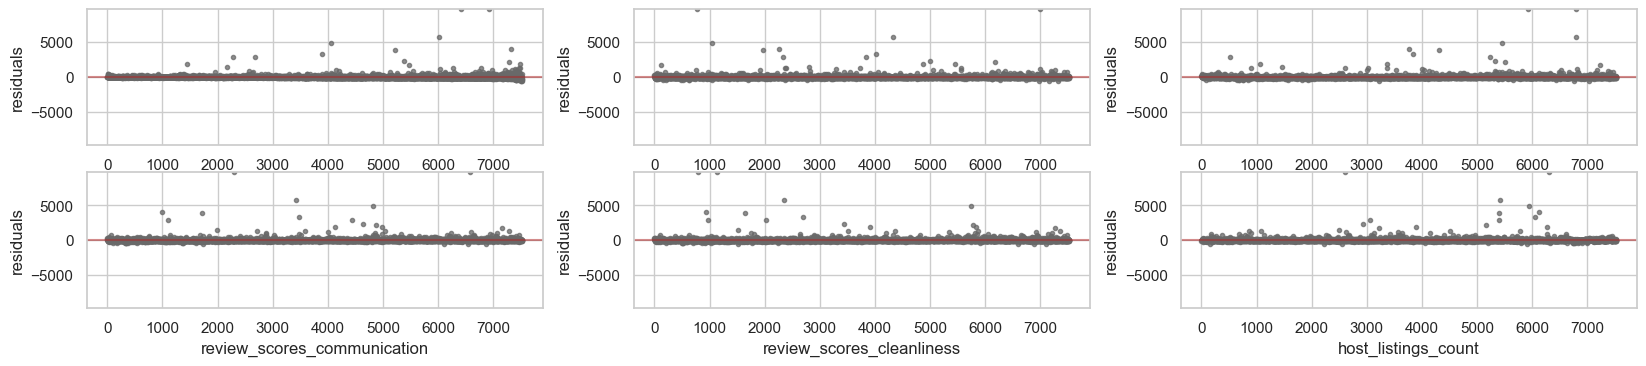

In [32]:
residuals1 = plot_residuals(result1, ['accommodates',
                                 'review_scores_value',
                                 'review_scores_location',
                                 'review_scores_communication',
                                 'review_scores_cleanliness',
                                 'host_listings_count'])